In [1]:
import numpy as np
import pandas as pd
from scipy import stats

import warnings
warnings.filterwarnings(action='ignore')

import folium
KC_coord = (47.4081,-121.9949)
Seattle_coord = (47.6062,-122.3321)
import matplotlib.pyplot as plt
from matplotlib import ticker
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn-notebook')
from yellowbrick.regressor import ResidualsPlot

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.dummy import DummyRegressor
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OrdinalEncoder, OneHotEncoder

In [2]:
# specify parse date to avoid object dtype for dates
df = pd.read_csv('./data/kc_house_data_22.csv', parse_dates=['date']) 
df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,...,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,lat,long
0,7399300360,2022-05-24,675000.0,4,1.0,1180,7140,1.0,NO,NO,...,PUBLIC,1180,0,0,40,1969,0,"2102 Southeast 21st Court, Renton, Washington ...",47.461975,-122.19052
1,8910500230,2021-12-13,920000.0,5,2.5,2770,6703,1.0,NO,NO,...,PUBLIC,1570,1570,0,240,1950,0,"11231 Greenwood Avenue North, Seattle, Washing...",47.711525,-122.35591
2,1180000275,2021-09-29,311000.0,6,2.0,2880,6156,1.0,NO,NO,...,PUBLIC,1580,1580,0,0,1956,0,"8504 South 113th Street, Seattle, Washington 9...",47.502045,-122.22520
3,1604601802,2021-12-14,775000.0,3,3.0,2160,1400,2.0,NO,NO,...,PUBLIC,1090,1070,200,270,2010,0,"4079 Letitia Avenue South, Seattle, Washington...",47.566110,-122.29020
4,8562780790,2021-08-24,592500.0,2,2.0,1120,758,2.0,NO,NO,...,PUBLIC,1120,550,550,30,2012,0,"2193 Northwest Talus Drive, Issaquah, Washingt...",47.532470,-122.07188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30150,7834800180,2021-11-30,1555000.0,5,2.0,1910,4000,1.5,NO,NO,...,PUBLIC,1600,1130,0,210,1921,0,"4673 Eastern Avenue North, Seattle, Washington...",47.664740,-122.32940
30151,194000695,2021-06-16,1313000.0,3,2.0,2020,5800,2.0,NO,NO,...,PUBLIC,2020,0,0,520,2011,0,"4131 44th Avenue Southwest, Seattle, Washingto...",47.565610,-122.38851
30152,7960100080,2022-05-27,800000.0,3,2.0,1620,3600,1.0,NO,NO,...,PUBLIC,940,920,240,110,1995,0,"910 Martin Luther King Jr Way, Seattle, Washin...",47.610395,-122.29585
30153,2781280080,2022-02-24,775000.0,3,2.5,2570,2889,2.0,NO,NO,...,PUBLIC,1830,740,480,100,2006,0,"17127 114th Avenue Southeast, Renton, Washingt...",47.449490,-122.18908


In [3]:
len(df)

30155

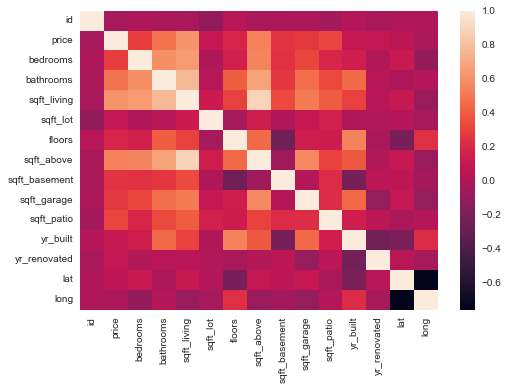

In [4]:
sns.heatmap(df.corr());

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30155 entries, 0 to 30154
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             30155 non-null  int64         
 1   date           30155 non-null  datetime64[ns]
 2   price          30155 non-null  float64       
 3   bedrooms       30155 non-null  int64         
 4   bathrooms      30155 non-null  float64       
 5   sqft_living    30155 non-null  int64         
 6   sqft_lot       30155 non-null  int64         
 7   floors         30155 non-null  float64       
 8   waterfront     30155 non-null  object        
 9   greenbelt      30155 non-null  object        
 10  nuisance       30155 non-null  object        
 11  view           30155 non-null  object        
 12  condition      30155 non-null  object        
 13  grade          30155 non-null  object        
 14  heat_source    30123 non-null  object        
 15  sewer_system   3014

# Set Zipcode

In [6]:
df['address'][4]

'2193 Northwest Talus Drive, Issaquah, Washington 98027, United States'

In [7]:
zipcode = []

for zips in df['address']:
    zipcode.append(int(zips[-20:-15]))
    
df['zipcode'] = zipcode
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,...,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,lat,long,zipcode
0,7399300360,2022-05-24,675000.0,4,1.0,1180,7140,1.0,NO,NO,...,1180,0,0,40,1969,0,"2102 Southeast 21st Court, Renton, Washington ...",47.461975,-122.19052,98055
1,8910500230,2021-12-13,920000.0,5,2.5,2770,6703,1.0,NO,NO,...,1570,1570,0,240,1950,0,"11231 Greenwood Avenue North, Seattle, Washing...",47.711525,-122.35591,98133
2,1180000275,2021-09-29,311000.0,6,2.0,2880,6156,1.0,NO,NO,...,1580,1580,0,0,1956,0,"8504 South 113th Street, Seattle, Washington 9...",47.502045,-122.22520,98178
3,1604601802,2021-12-14,775000.0,3,3.0,2160,1400,2.0,NO,NO,...,1090,1070,200,270,2010,0,"4079 Letitia Avenue South, Seattle, Washington...",47.566110,-122.29020,98118
4,8562780790,2021-08-24,592500.0,2,2.0,1120,758,2.0,NO,NO,...,1120,550,550,30,2012,0,"2193 Northwest Talus Drive, Issaquah, Washingt...",47.532470,-122.07188,98027


# Drop NaNs

In [8]:
df.isna().sum()

id                0
date              0
price             0
bedrooms          0
bathrooms         0
sqft_living       0
sqft_lot          0
floors            0
waterfront        0
greenbelt         0
nuisance          0
view              0
condition         0
grade             0
heat_source      32
sewer_system     14
sqft_above        0
sqft_basement     0
sqft_garage       0
sqft_patio        0
yr_built          0
yr_renovated      0
address           0
lat               0
long              0
zipcode           0
dtype: int64

In [9]:
#df.dropna(inplace=True)

### Heat Source

In [10]:
heat_count = print(df['heat_source'].value_counts())

Gas                  20583
Electricity           6465
Oil                   2899
Gas/Solar               93
Electricity/Solar       59
Other                   20
Oil/Solar                4
Name: heat_source, dtype: int64


In [11]:
df['heat_source'].fillna('Gas', inplace=True)

In [12]:
df.isna().sum()

id                0
date              0
price             0
bedrooms          0
bathrooms         0
sqft_living       0
sqft_lot          0
floors            0
waterfront        0
greenbelt         0
nuisance          0
view              0
condition         0
grade             0
heat_source       0
sewer_system     14
sqft_above        0
sqft_basement     0
sqft_garage       0
sqft_patio        0
yr_built          0
yr_renovated      0
address           0
lat               0
long              0
zipcode           0
dtype: int64

### Sewer System

In [13]:
heat_count = print(df['sewer_system'].value_counts())

PUBLIC                25777
PRIVATE                4355
PRIVATE RESTRICTED        6
PUBLIC RESTRICTED         3
Name: sewer_system, dtype: int64


In [14]:
df['sewer_system'].fillna('PUBLIC', inplace=True)

In [15]:
df.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
greenbelt        0
nuisance         0
view             0
condition        0
grade            0
heat_source      0
sewer_system     0
sqft_above       0
sqft_basement    0
sqft_garage      0
sqft_patio       0
yr_built         0
yr_renovated     0
address          0
lat              0
long             0
zipcode          0
dtype: int64

# Train-Test Split

In [16]:
y = df['price']
X = df.drop('price', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.25)

# Helper Functions

ohe executes 2 transformations, test and train. data for any given input variable: First, we use OneHotEncoder to split up our categorical variables. Second, we run a linear regression on encoded values using .fit(). Then, it takes in a training df ('df'), a test df ('df2') and a column name. Next, it returns the training df and the test df concatenated with newly encoded columns. Lastly, we return a list of these newly encoded column names. 

In [17]:
def ohe(df, df2, column):
    for col in column:
        train = df[[col]]
        ohe = OneHotEncoder(drop='first', sparse=False, handle_unknown="ignore")
        ohe.fit(train)
        encoded_train = ohe.transform(train)
        col_labels = [f"{col}_{f}" for f in ohe.get_feature_names()]
        encoded_train = pd.DataFrame(encoded_train, columns=col_labels, index=df.index)
        df = pd.concat([df, encoded_train], axis=1)
        
        test = df2[[col]]
        encoded_test = ohe.transform(test)
        col_labels = [f"{col}_{f}" for f in ohe.get_feature_names()]
        encoded_test = pd.DataFrame(encoded_test, columns=col_labels, index=df2.index)
        df2 = pd.concat([df2, encoded_test], axis=1)
        
    return df, df2, encoded_train.columns.tolist()

We run a Standard Scaler to scale all the values in the test data and training data so that our models results are in comparable units. Then, we score the scaled data to get the R2 to assess the strength of our model.

In [18]:
def scale_score(x, y, x2, y2):
    scaler = StandardScaler()
    scaler.fit(x)
    X_train_scaled = scaler.transform(x)
    X_test_scaled = scaler.transform(x2)

    lr = LinearRegression()
    lr.fit(X_train_scaled,y_train)

    train_preds = lr.predict(X_train_scaled)
    test_preds = lr.predict(X_test_scaled)
    
    print(f"""training score: {r2_score(y_train, train_preds)}
    test score: {r2_score(y_test, test_preds)}""")
    
    return X_train_scaled, X_test_scaled, train_preds, test_preds

Uses price and predictions to calculate Mean Absolute Error (MAE), Mean Squared Error (MSE) and Root Mean Squared Error (RSME) for the training and testing data sets. We will compare these values to evaluate model performance.

In [19]:
def get_train_test_metrics(y_train, train_preds,
               y_test, test_preds):
    """
    Prints different training and testing metrics, namely R2, MAE, MSE, RMSE
    """
    print("\nTraining Metrics:")
    print(f"R2: {r2_score(y_train, train_preds):.3f}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_train, train_preds):.3f}")
    print(f"Mean Squared Error: {mean_squared_error(y_train, train_preds):.3f}")
    print(f"Root Mean Squared Error: {mean_squared_error(y_train, train_preds, squared=False):.3f}")
    
    print("\nTesting Metrics:")
    print(f"R2: {r2_score(y_test, test_preds):.3f}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_test, test_preds):.3f}")
    print(f"Mean Squared Error: {mean_squared_error(y_test, test_preds):.3f}")
    print(f"Root Mean Squared Error: {mean_squared_error(y_test, test_preds, squared=False):.3f}")

# Outliers

### Price

In [20]:
# calculate 25, 75, iqr, whiskers for 'price'
price_q75, price_q25 = np.percentile(df['price'], [75, 25])
price_iqr = price_q75 - price_q25
price_min = price_q25 - (1.5 * price_iqr)
price_max = price_q75 + (1.5 * price_iqr)

print(f"""price_min: {price_min} 
price_max: {price_max}""")

price_min: -330000.0 
price_max: 2278000.0


In [21]:
df = df[df['price'] >= price_min]
df = df[df['price'] <= price_max]

### Sqft Lot

In [22]:
# calculate 25, 75, iqr, whiskers for 'sqft_lot'
sqft_lot_q25, sqft_lot_q75 = np.percentile(df['sqft_lot'], [25, 75])
sqft_lot_iqr = sqft_lot_q75 - sqft_lot_q25
sqft_lot_min = sqft_lot_q25 - (1.5 * sqft_lot_iqr)
sqft_lot_max = sqft_lot_q75 + (1.5 * sqft_lot_iqr)


print(f"""sqft_lot_min: {sqft_lot_min} 
sqft_lot_max: {sqft_lot_max}""")

sqft_lot_min: -3378.0 
sqft_lot_max: 18246.0


In [23]:
# set df to include everything within the whiskers except the outliers
df = df[df['sqft_lot'] >= sqft_lot_min]
df = df[df['sqft_lot'] <= sqft_lot_max]

# Categorical Variables

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25027 entries, 0 to 30154
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             25027 non-null  int64         
 1   date           25027 non-null  datetime64[ns]
 2   price          25027 non-null  float64       
 3   bedrooms       25027 non-null  int64         
 4   bathrooms      25027 non-null  float64       
 5   sqft_living    25027 non-null  int64         
 6   sqft_lot       25027 non-null  int64         
 7   floors         25027 non-null  float64       
 8   waterfront     25027 non-null  object        
 9   greenbelt      25027 non-null  object        
 10  nuisance       25027 non-null  object        
 11  view           25027 non-null  object        
 12  condition      25027 non-null  object        
 13  grade          25027 non-null  object        
 14  heat_source    25027 non-null  object        
 15  sewer_system   2502

In [25]:
df.drop(['id', 'date', 'greenbelt', 'sqft_garage', 'sqft_basement'], axis=1, inplace=True)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25027 entries, 0 to 30154
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         25027 non-null  float64
 1   bedrooms      25027 non-null  int64  
 2   bathrooms     25027 non-null  float64
 3   sqft_living   25027 non-null  int64  
 4   sqft_lot      25027 non-null  int64  
 5   floors        25027 non-null  float64
 6   waterfront    25027 non-null  object 
 7   nuisance      25027 non-null  object 
 8   view          25027 non-null  object 
 9   condition     25027 non-null  object 
 10  grade         25027 non-null  object 
 11  heat_source   25027 non-null  object 
 12  sewer_system  25027 non-null  object 
 13  sqft_above    25027 non-null  int64  
 14  sqft_patio    25027 non-null  int64  
 15  yr_built      25027 non-null  int64  
 16  yr_renovated  25027 non-null  int64  
 17  address       25027 non-null  object 
 18  lat           25027 non-nu

### Bedrooms

In [27]:
bed_count = df['bedrooms'].value_counts()
bed_count

3     11060
4      7613
2      3604
5      2001
6       335
1       281
7        56
0        32
8        29
9        13
10        2
11        1
Name: bedrooms, dtype: int64

In [28]:
#df = df[df['bedrooms'] != 7]
#df = df[df['bedrooms'] != 8]
#df = df[df['bedrooms'] != 9]
#df = df[df['bedrooms'] != 10]
#df = df[df['bedrooms'] != 11]

### Condition

In [29]:
condition_count = df['condition'].value_counts()
condition_count

Average      15585
Good          6572
Very Good     2671
Fair           156
Poor            43
Name: condition, dtype: int64

In [30]:
X_train, X_test, encoded_condition = ohe(X_train, X_test, ['condition'])

In [31]:
X_train['condition'] = X_train['condition'].map({'Very Good': 5, 'Good': 4, 'Average': 3, 'Fair': 2, 'Poor': 1})

In [32]:
X_test['condition'] = X_test['condition'].map({'Very Good': 5, 'Good': 4, 'Average': 3, 'Fair': 2, 'Poor': 1})

### Floors

In [33]:
floor_count = print(df['floors'].value_counts())

1.0    11895
2.0     9771
1.5     2055
3.0     1134
2.5      127
4.0       30
3.5       15
Name: floors, dtype: int64


In [34]:
X_train, X_test, encoded_floors = ohe(X_train, X_test, ['floors'])

In [35]:
#X_train['floors'] = X_train['floors'].map({1.0: 1, 1.5: 1, 2.0: 2, 2.5: 2, 3.0: 3, 3.5: 3, 4.0: 4})

In [36]:
#X_test['floors'] = X_test['floors'].map({1.0: 1, 1.5: 1, 2.0: 2, 2.5: 2, 3.0: 3, 3.5: 3, 4.0: 4})

### Grade

In [37]:
grade_count = print(df['grade'].value_counts())

7 Average        10684
8 Good            8204
9 Better          2696
6 Low Average     2553
10 Very Good       499
5 Fair             293
11 Excellent        56
4 Low               31
3 Poor               8
12 Luxury            3
Name: grade, dtype: int64


In [38]:
X_train, X_test, encoded_grade = ohe(X_train, X_test, ['grade'])

In [39]:
#df = df[df['grade'] != '3 Poor']
#df = df[df['grade'] != '2 Substandard']
#df = df[df['grade'] != '13 Mansion']
#df = df[df['grade'] != '12 Luxury']

### Nuisance

In [40]:
nuisance_count = print(df['nuisance'].value_counts())

NO     20779
YES     4248
Name: nuisance, dtype: int64


In [41]:
X_train, X_test, encoded_nuisance = ohe(X_train, X_test, ['nuisance'])

In [42]:
X_train['nuisance'] = X_train['nuisance'].map({'NO': 0, 'YES': 1})

In [43]:
X_test['nuisance'] = X_test['nuisance'].map({'NO': 0, 'YES': 1})

### View

In [44]:
view_count = df['view'].value_counts()
view_count

NONE         22808
AVERAGE       1364
GOOD           501
EXCELLENT      192
FAIR           162
Name: view, dtype: int64

In [45]:
X_train['view'].fillna('NONE', inplace=True)
X_test['view'].fillna('NONE', inplace=True)

In [46]:
X_train, X_test, encoded_view = ohe(X_train, X_test, ['view'])

In [47]:
X_train['view'] = X_train['view'].map({'EXCELLENT': 5, 'GOOD': 4, 'AVERAGE': 3, 'FAIR': 2, 'NONE': 1})

In [48]:
X_test['view'] = X_test['view'].map({'EXCELLENT': 5, 'GOOD': 4, 'AVERAGE': 3, 'FAIR': 2, 'NONE': 1})

### Waterfront

In [49]:
waterfront_count = print(df['waterfront'].value_counts())

NO     24886
YES      141
Name: waterfront, dtype: int64


In [50]:
X_train, X_test, encoded_waterfront = ohe(X_train, X_test, ['waterfront'])

In [51]:
X_train['waterfront'] = X_train['waterfront'].map({'NO': 0, 'YES': 1})

In [52]:
X_test['waterfront'] = X_test['waterfront'].map({'NO': 0, 'YES': 1})

### Zipcode

In [53]:
zipcode_count = print(df['zipcode'].sort_values().value_counts())

98042    789
98103    740
98117    734
98115    719
98038    697
        ... 
85040      1
85207      1
85210      1
85295      1
99705      1
Name: zipcode, Length: 381, dtype: int64


In [54]:
X_train, X_test, encoded_zipcode = ohe(X_train, X_test, ['zipcode'])

# Models

In [55]:
dummy = DummyRegressor()
dummy.fit(X_train, y_train)
basemodel_dummy_score = dummy.score(X_train, y_train)
test_dummy_score = dummy.score(X_test, y_test)

print(f"""basemodel_dummy_score: {basemodel_dummy_score}

test_dummy_score: {test_dummy_score}""")

basemodel_dummy_score: 0.0

test_dummy_score: -0.00014685597742913892


In [56]:
df.corr()['price'].abs().sort_values(ascending=False)

price           1.000000
sqft_living     0.557284
sqft_above      0.455312
bathrooms       0.425413
bedrooms        0.319345
sqft_patio      0.227199
floors          0.182945
lat             0.082277
yr_renovated    0.064573
sqft_lot        0.058544
yr_built        0.051270
long            0.028288
zipcode         0.025380
Name: price, dtype: float64

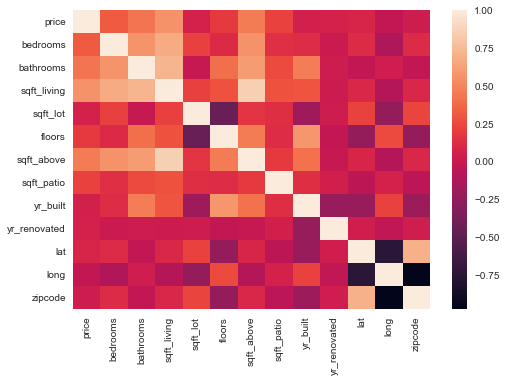

In [85]:
sns.heatmap(df.corr());

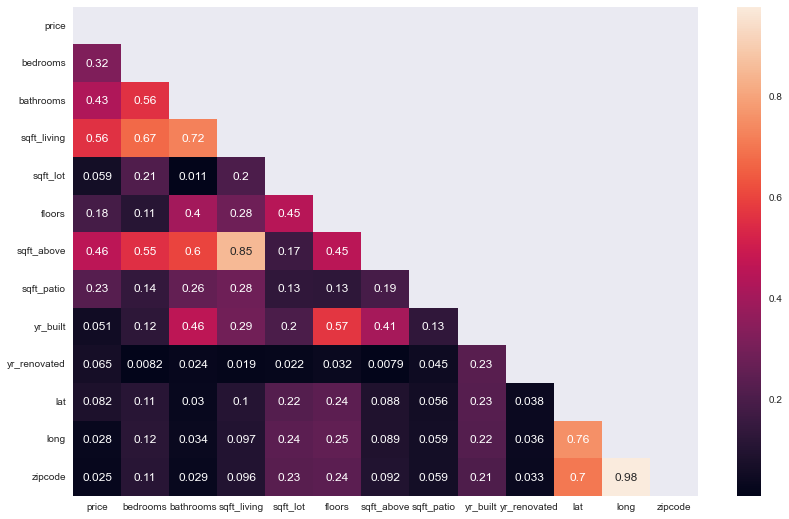

In [86]:
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(14, 9))
    
    mask = np.triu(np.ones_like(df.corr(), dtype=bool))
    ax = sns.heatmap(abs(df.corr()),mask=mask,annot=True)
    fig.savefig('images/Corelation_Heatmap_22',bbox_inches="tight");

### Model 1

In [58]:
cols = ['sqft_living']

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [59]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.3545318612074395
    test score: 0.42118487085545475


In [60]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.355
Mean Absolute Error: 399518.374
Mean Squared Error: 528272137494.287
Root Mean Squared Error: 726823.319

Testing Metrics:
R2: 0.421
Mean Absolute Error: 384865.212
Mean Squared Error: 439056274785.104
Root Mean Squared Error: 662613.217


### Model 2

In [61]:
cols = encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [62]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.3724566144157947
    test score: 0.4008540952759744


In [63]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.372
Mean Absolute Error: 361458.267
Mean Squared Error: 513601935942.358
Root Mean Squared Error: 716660.265

Testing Metrics:
R2: 0.401
Mean Absolute Error: 362838.997
Mean Squared Error: 454478046158.998
Root Mean Squared Error: 674149.869


### Model 3

In [64]:
cols = encoded_grade

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [65]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.40128938304739414
    test score: 0.43596346309366285


In [66]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.401
Mean Absolute Error: 386963.853
Mean Squared Error: 490004259466.202
Root Mean Squared Error: 700003.042

Testing Metrics:
R2: 0.436
Mean Absolute Error: 384034.288
Mean Squared Error: 427846074277.274
Root Mean Squared Error: 654099.438


### Model 4

In [67]:
cols = encoded_view

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [68]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.11564627159653729
    test score: 0.12235429609378379


In [69]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.116
Mean Absolute Error: 500719.855
Mean Squared Error: 723783880763.913
Root Mean Squared Error: 850754.889

Testing Metrics:
R2: 0.122
Mean Absolute Error: 495293.256
Mean Squared Error: 665732172391.066
Root Mean Squared Error: 815924.122


### Model 5

In [70]:
cols = encoded_waterfront

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [71]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.05172493999469607
    test score: 0.06085018296741418


In [72]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.052
Mean Absolute Error: 525119.731
Mean Squared Error: 776099179455.422
Root Mean Squared Error: 880964.914

Testing Metrics:
R2: 0.061
Mean Absolute Error: 520210.420
Mean Squared Error: 712385698592.317
Root Mean Squared Error: 844029.442


### Model 6

In [73]:
cols = encoded_grade + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [74]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.612629838366135
    test score: 0.6506308392158315


In [75]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.613
Mean Absolute Error: 276578.161
Mean Squared Error: 317036350811.415
Root Mean Squared Error: 563059.811

Testing Metrics:
R2: 0.651
Mean Absolute Error: 278541.676
Mean Squared Error: 265011597892.060
Root Mean Squared Error: 514792.772


### Model 7

In [76]:
cols = ['sqft_living'] + encoded_grade + encoded_view + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [77]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.6488206410603194
    test score: 0.7050063087040151


In [78]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.649
Mean Absolute Error: 249374.568
Mean Squared Error: 287416619723.441
Root Mean Squared Error: 536112.507

Testing Metrics:
R2: 0.705
Mean Absolute Error: 243544.695
Mean Squared Error: 223765455780.230
Root Mean Squared Error: 473038.535


### Model 8

In [79]:
cols = ['sqft_living'] + encoded_grade + encoded_view + encoded_waterfront + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [80]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.6559280213871649
    test score: 0.7162776208983692


In [81]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.656
Mean Absolute Error: 250533.380
Mean Squared Error: 281599708288.786
Root Mean Squared Error: 530659.692

Testing Metrics:
R2: 0.716
Mean Absolute Error: 242547.973
Mean Squared Error: 215215678666.928
Root Mean Squared Error: 463913.439


### Model 9

In [82]:
cols = ['bathrooms', 'bedrooms', 'floors', 'sqft_living', 'yr_built'] + encoded_zipcode + encoded_grade + encoded_view + encoded_waterfront

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [83]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.6570307767503236
    test score: 0.7172738471349496


In [84]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.657
Mean Absolute Error: 249863.788
Mean Squared Error: 280697177400.246
Root Mean Squared Error: 529808.623

Testing Metrics:
R2: 0.717
Mean Absolute Error: 241534.917
Mean Squared Error: 214459998038.948
Root Mean Squared Error: 463098.260
